## Section 1 — Import Libraries

In this section, we import all the required Python libraries used for:

- Loading and visualizing images
- Training the YOLO detection model
- Handling file paths

These imports prepare the environment for the rest of the project.

In [16]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt

from ultralytics import YOLO



In [17]:
dataset_path = Path("archive/images")

# List first 5 image filenames (PNG files)
image_files = sorted(dataset_path.glob("*.png"))

print("Number of images:", len(image_files))
print("First 5 images:", image_files[:5])

Number of images: 433
First 5 images: [WindowsPath('archive/images/Cars0.png'), WindowsPath('archive/images/Cars1.png'), WindowsPath('archive/images/Cars10.png'), WindowsPath('archive/images/Cars100.png'), WindowsPath('archive/images/Cars101.png')]


## Section 2 — Dataset Exploration

Before training a detection model, we first explore the dataset to understand what the images look like.  
We will:

- Load sample images  
- Visualize them  
- Confirm the dataset paths are correct  

This helps ensure that the model receives the right type of input and that the dataset structure is properly recognized.


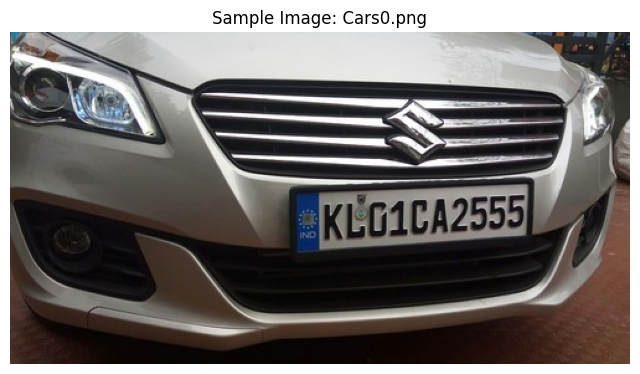

In [18]:
# Display one sample image

sample_img_path = image_files[0]  # first image in the dataset

# Load image using OpenCV (BGR format)
img = cv2.imread(str(sample_img_path))

# Convert BGR → RGB for correct display
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Show image
plt.figure(figsize=(8, 6))
plt.imshow(img_rgb)
plt.axis("off")
plt.title(f"Sample Image: {sample_img_path.name}")
plt.show()

## Section 3 — Annotations and YOLO Format

The original dataset provides bounding box annotations in **Pascal VOC (XML) format**.  
However, the YOLO model expects annotations in a different text format:

`class_id x_center y_center width height`

All coordinates are **normalized** (between 0 and 1), relative to the image size.

In this section, we:
- Read the XML annotation files
- Extract the license plate bounding box
- Convert each annotation to YOLO format
- Save the result as a `.txt` file for each image


In [19]:
import xml.etree.ElementTree as ET

annotations_path = Path("archive/annotations")
labels_path = Path("archive/labels_yolo")

# Create output folder for YOLO labels
labels_path.mkdir(exist_ok=True)

# We have only ONE class: license plate
class_id = 0

def convert_bbox_to_yolo(size, bbox):
    """
    size: (image_width, image_height)
    bbox: (xmin, ymin, xmax, ymax)
    returns: (x_center, y_center, width, height) normalized between 0 and 1
    """
    img_w, img_h = size
    xmin, ymin, xmax, ymax = bbox

    x_center = (xmin + xmax) / 2.0 / img_w
    y_center = (ymin + ymax) / 2.0 / img_h
    width = (xmax - xmin) / img_w
    height = (ymax - ymin) / img_h

    return x_center, y_center, width, height


num_files = 0

for xml_file in annotations_path.glob("*.xml"):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # image size
    img_w = int(root.find("size/width").text)
    img_h = int(root.find("size/height").text)

    # each object = one license plate
    yolo_lines = []

    for obj in root.findall("object"):
        # name = class label, here it's always license-plate-like
        # you could check obj.find("name").text if needed
        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        x_c, y_c, w, h = convert_bbox_to_yolo((img_w, img_h), (xmin, ymin, xmax, ymax))
        yolo_lines.append(f"{class_id} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}")

    # Save .txt file with same base name as image
    txt_filename = labels_path / (xml_file.stem + ".txt")
    with open(txt_filename, "w") as f:
        for line in yolo_lines:
            f.write(line + "\n")

    num_files += 1

print(f"Converted {num_files} annotation files to YOLO format.")
print("YOLO label samples from 'archive/labels_yolo':", list(labels_path.glob('*.txt'))[:5])

Converted 433 annotation files to YOLO format.
YOLO label samples from 'archive/labels_yolo': [WindowsPath('archive/labels_yolo/Cars0.txt'), WindowsPath('archive/labels_yolo/Cars1.txt'), WindowsPath('archive/labels_yolo/Cars10.txt'), WindowsPath('archive/labels_yolo/Cars100.txt'), WindowsPath('archive/labels_yolo/Cars101.txt')]


## Section 4 — Preparing YOLO Dataset (Train / Validation Split)

To train YOLO, we need a specific folder structure with separate sets for training and validation:

- `images/train` and `images/val`
- `labels/train` and `labels/val`

In this section, we:
- Pair each image with its corresponding YOLO label file  
- Randomly split the dataset into training (e.g., 80%) and validation (20%)  
- Copy the files into a new `yolo_dataset` folder with the structure expected by YOLO.


In [20]:
import random
import shutil

# Use the same dataset and labels paths as before
images_path = Path("archive/images")
labels_path = Path("archive/labels_yolo")

# Make sure images are sorted (for consistency only)
all_images = sorted(images_path.glob("*.png"))

# Pair each image with its corresponding label file
image_label_pairs = []
for img_path in all_images:
    label_path = labels_path / (img_path.stem + ".txt")
    if label_path.exists():
        image_label_pairs.append((img_path, label_path))
    else:
        print(f"Warning: no label for image {img_path.name}")

print("Total paired image+label files:", len(image_label_pairs))

# Shuffle and split into train and validation sets (80% / 20%)
random.shuffle(image_label_pairs)
split_idx = int(0.8 * len(image_label_pairs))

train_pairs = image_label_pairs[:split_idx]
val_pairs = image_label_pairs[split_idx:]

print(f"Training samples: {len(train_pairs)}")
print(f"Validation samples: {len(val_pairs)}")

# Create YOLO-style directory structure
yolo_base = Path("yolo_dataset")
images_train_dir = yolo_base / "images" / "train"
images_val_dir = yolo_base / "images" / "val"
labels_train_dir = yolo_base / "labels" / "train"
labels_val_dir = yolo_base / "labels" / "val"

for d in [images_train_dir, images_val_dir, labels_train_dir, labels_val_dir]:
    d.mkdir(parents=True, exist_ok=True)

# Copy files into their respective folders
def copy_pairs(pairs, img_dest_dir, label_dest_dir):
    for img_path, label_path in pairs:
        shutil.copy2(img_path, img_dest_dir / img_path.name)
        shutil.copy2(label_path, label_dest_dir / label_path.name)

copy_pairs(train_pairs, images_train_dir, labels_train_dir)
copy_pairs(val_pairs, images_val_dir, labels_val_dir)

print("Finished copying files into yolo_dataset folder.")

Total paired image+label files: 433
Training samples: 346
Validation samples: 87
Finished copying files into yolo_dataset folder.


## Section 5 — Training the YOLO Detection Model

In this section, we fine-tune a pretrained **YOLOv8** object detection model on our license plate dataset.

Key ideas:
- We start from a pretrained model (`yolov8n.pt`) so training is faster and easier.
- We use the `data.yaml` file to tell YOLO where the images and labels are.
- The model learns to detect and localize license plates by seeing many examples.

We will:
- Load the YOLOv8 model
- Train it on the `yolo_dataset` (train/val)
- Save the trained weights and training metrics for evaluation


In [ ]:
# Load a pretrained YOLOv8 model (nano version: small and fast)
model = YOLO("yolov8n.pt")  # this will download the weights if not already present

# Train the model on our license plate dataset
results = model.train(
    data="data.yaml",   # path to our dataset config
    epochs=20,          
    imgsz=640,          # image size
    batch=16           
)

Ultralytics 8.3.229  Python-3.13.2 torch-2.9.1+cpu CPU (Intel Core i7-8665U 1.90GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

In [1]:
# Install once in the notebook (you can comment it out after it’s installed)
!pip install easyocr

import easyocr

# Initialize OCR reader (add other languages if needed)
reader = easyocr.Reader(['en'], gpu=False)  # set gpu=True if you have GPU support


  Using cached easyocr-1.7.2-py3-none-any.whl.metadata (10 kB)
INFO: pip is looking at multiple versions of easyocr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of easyocr to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.5 MB ? eta -:--:--
     ---------------------------------------- 

ERROR: Cannot install easyocr==1.0, easyocr==1.1, easyocr==1.1.1, easyocr==1.1.10, easyocr==1.1.2, easyocr==1.1.3, easyocr==1.1.4, easyocr==1.1.5, easyocr==1.1.6, easyocr==1.1.7, easyocr==1.1.8, easyocr==1.1.9, easyocr==1.2, easyocr==1.2.1, easyocr==1.2.2, easyocr==1.2.3, easyocr==1.2.4, easyocr==1.2.5, easyocr==1.2.5.1, easyocr==1.3, easyocr==1.3.0.1, easyocr==1.3.1, easyocr==1.3.2, easyocr==1.4, easyocr==1.4.1, easyocr==1.4.2, easyocr==1.5.0, easyocr==1.6.0, easyocr==1.6.1, easyocr==1.6.2, easyocr==1.7.0, easyocr==1.7.1 and easyocr==1.7.2 because these package versions have conflicting dependencies.

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: c:\msys64\ucrt64\bin\python.exe -m pip install --upgrade pip
ERROR: ResolutionImpossible: for help visit https://pip.pypa.io/en/latest/topics/dependency-resolution/#dealing-with-dependency-conflicts
Using CPU. Note: This module is much faster with a GPU.


Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

## Section 6 — Evaluation and Visualization of Detected License Plates

After training the YOLO model, we evaluate its performance and visualize its predictions.

Key points:
- We use the trained model to run inference on validation images.
- The model draws bounding boxes around the detected license plates.
- These visual results help us understand how well the model works in real scenarios.

In this section, we:
- Load the best trained model checkpoint
- Run detection on sample images
- Display the images with predicted bounding boxes


In [21]:
# Load the trained YOLO model
best_model_path = "runs/detect/train/weights/best.pt"
trained_model = YOLO(best_model_path)
print("Loaded trained model from:", best_model_path)


Loaded trained model from: runs/detect/train/weights/best.pt


Using validation image: Cars100.png


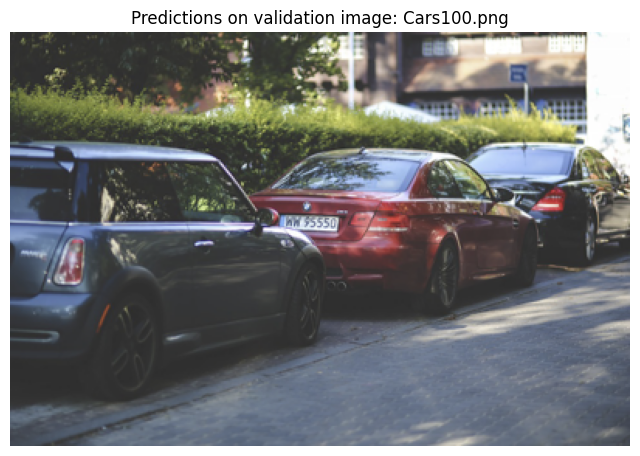

In [22]:
# Pick one sample image from the validation set
sample_val_image = next(images_val_dir.glob("*.png"))
print("Using validation image:", sample_val_image.name)

# Run detection
results = trained_model.predict(source=str(sample_val_image), conf=0.25, verbose=False)

# Get the first result and plot it
res = results[0]
annotated_img = res.plot()  # this returns a BGR image with boxes drawn

# Convert BGR -> RGB for display
annotated_img_rgb = cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 6))
plt.imshow(annotated_img_rgb)
plt.axis("off")
plt.title(f"Predictions on validation image: {sample_val_image.name}")
plt.show()

### Section 6.1 — Generating Result Images for the Report and Slides

To illustrate the performance of our model, we generate predictions on a few **validation images** (images not seen during training).

In this subsection, we:
- Select 3 random images from the validation set  
- Run the trained YOLO model on each image  
- Visualize the detected license plates  
- Save the resulting images to disk for use in the presentation slides


Selected validation images:
 - Cars171.png
 - Cars80.png
 - Cars11.png


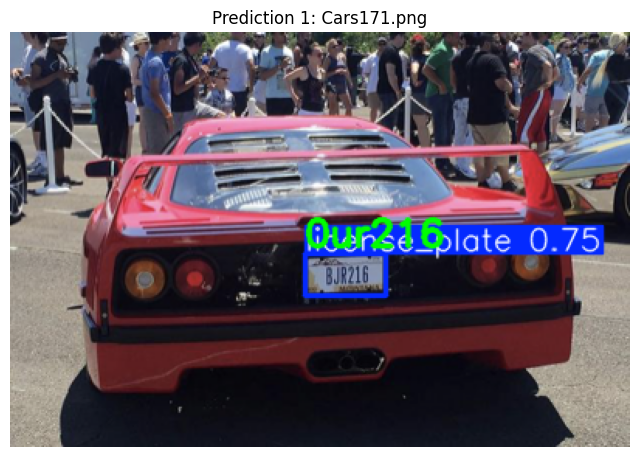

Saved: result_images\prediction_1_Cars171.png


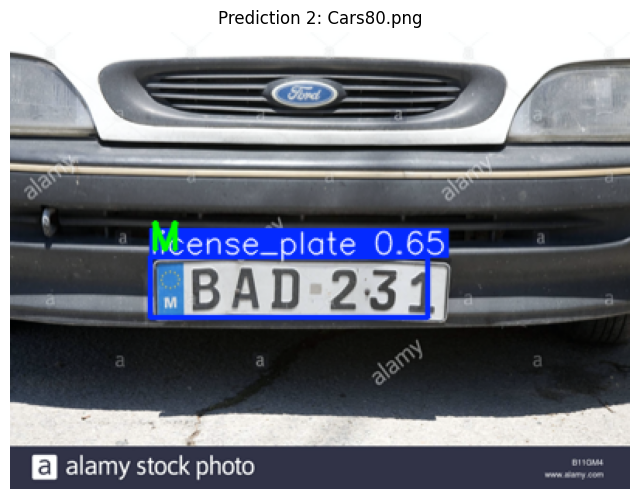

Saved: result_images\prediction_2_Cars80.png


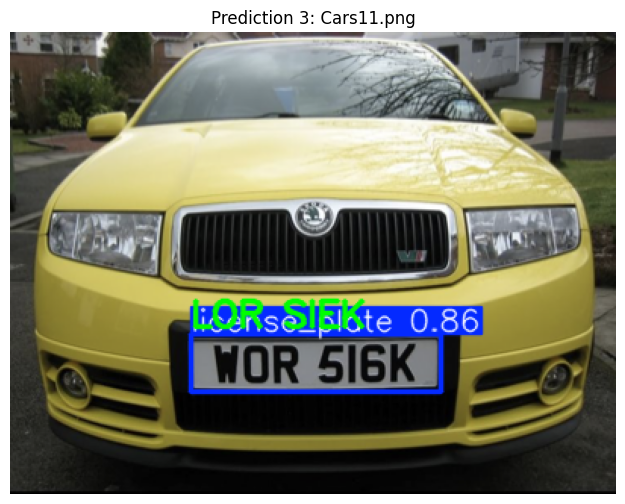

Saved: result_images\prediction_3_Cars11.png


In [27]:
import random
from pathlib import Path

val_images_dir = Path("yolo_dataset/images/val")

# Create an output folder for slide-ready result images
results_dir = Path("result_images")
results_dir.mkdir(exist_ok=True)

# Get all validation images (PNG)
val_images = sorted(val_images_dir.glob("*.png"))

# Pick 3 random validation images
sample_val_images = random.sample(val_images, 3)
print("Selected validation images:")
for p in sample_val_images:
    print(" -", p.name)

for i, img_path in enumerate(sample_val_images, start=1):
    # Run detection
    results = trained_model.predict(source=str(img_path), conf=0.25, verbose=False)
    res = results[0]

    # Original image (BGR) from YOLO result
    orig_img = res.orig_img.copy()

    # Copy used for drawing boxes + text
    annotated = res.plot()  # BGR

    # ---- 🔎 OCR on each detected license plate ----
    # Get bounding boxes, confidences, and class IDs
    boxes = res.boxes.xyxy.cpu().numpy()      # [x1, y1, x2, y2]
    scores = res.boxes.conf.cpu().numpy()
    cls_ids = res.boxes.cls.cpu().numpy()     # class indices

    # If you have only ONE class ("license plate"), cls_ids will all be 0.
    # Loop over each detection:
    for box, score, cls_id in zip(boxes, scores, cls_ids):
        # OPTIONAL: skip low-confidence boxes here if you want
        # if score < 0.5:
        #     continue

        x1, y1, x2, y2 = map(int, box)

        # Crop the license plate region from the original image
        plate_roi = orig_img[y1:y2, x1:x2]

        # Basic pre-processing to help OCR
        if plate_roi.size == 0:
            continue  # skip weird boxes
        plate_gray = cv2.cvtColor(plate_roi, cv2.COLOR_BGR2GRAY)
        plate_gray = cv2.resize(
            plate_gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC
        )

        # Run EasyOCR on the cropped plate
        ocr_results = reader.readtext(plate_gray)

        # Take the text with highest confidence (if any)
        plate_text = ""
        if len(ocr_results) > 0:
            # ocr_results is a list of (bbox, text, confidence)
            best = max(ocr_results, key=lambda x: x[2])
            plate_text = best[1]

        # Draw the OCR text above the bounding box on the annotated image
        if plate_text:
            cv2.putText(
                annotated,
                plate_text,
                (x1, max(y1 - 5, 0)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.8,
                (0, 255, 0),
                2,
                cv2.LINE_AA,
            )

    # ---------------------------------------- #
    # Convert to RGB for matplotlib display
    annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)

    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_rgb)
    plt.axis("off")
    plt.title(f"Prediction {i}: {img_path.name}")
    plt.show()

    # Save to disk for presentation
    out_path = results_dir / f"prediction_{i}_{img_path.stem}.png"
    cv2.imwrite(str(out_path), annotated)  # save in BGR
    print(f"Saved: {out_path}")


## Section 7 — Faster R-CNN Baseline (Two-Stage Detector)


In [ ]:
!pip install torch torchvision --quiet

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import numpy as np


In [ ]:
#Dataset that reads yolo_dataset and converts YOLO labels to RCNN format

from pathlib import Path
import cv2

class LicensePlateDataset(Dataset):
    def __init__(self, root_dir, split="train", transforms=None):
        self.root_dir = Path(root_dir)
        self.split = split
        self.transforms = transforms

        self.images_dir = self.root_dir / "images" / split
        self.labels_dir = self.root_dir / "labels" / split

        self.image_paths = sorted(
            list(self.images_dir.glob("*.png")) +
            list(self.images_dir.glob("*.jpg")) +
            list(self.images_dir.glob("*.jpeg"))
        )

        if len(self.image_paths) == 0:
            raise RuntimeError(f"No images found in {self.images_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label_path = self.labels_dir / (img_path.stem + ".txt")

        img = cv2.imread(str(img_path))
        if img is None:
            raise RuntimeError(f"Failed to read image: {img_path}")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape

        boxes = []
        labels = []

        if label_path.exists():
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        continue
                    cls_id, x_c, y_c, bw, bh = map(float, parts)

                    x_c *= w
                    y_c *= h
                    bw *= w
                    bh *= h

                    x1 = x_c - bw / 2.0
                    y1 = y_c - bh / 2.0
                    x2 = x_c + bw / 2.0
                    y2 = y_c + bh / 2.0

                    boxes.append([x1, y1, x2, y2])
                    labels.append(1)  # single class: license plate

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        image_id = torch.tensor([idx])
        area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": image_id,
            "area": area,
            "iscrowd": iscrowd,
        }

        img = F.to_tensor(img)

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target


In [ ]:
#Dataloaders for Faster R-CNN

def collate_fn(batch):
    return tuple(zip(*batch))

root_dir = "yolo_dataset"

train_dataset = LicensePlateDataset(root_dir, split="train")
val_dataset   = LicensePlateDataset(root_dir, split="val")

train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2,
    collate_fn=collate_fn
)

# Quick sanity check
images, targets = next(iter(train_loader))
print("Batch size:", len(images))
print("Target keys:", targets[0].keys())
print("Boxes shape:", targets[0]["boxes"].shape)


In [ ]:
#Build Faster R-CNN model for 1 class (license plate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.to(device)


In [ ]:
#Train Faster R-CNN (this is the only training we do here)

import time
from torch.optim.lr_scheduler import StepLR

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    start = time.time()

    for images, targets in train_loader:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        epoch_loss += loss_value

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()

    avg_loss = epoch_loss / len(train_loader)
    elapsed = time.time() - start
    print(f"Epoch [{epoch+1}/{num_epochs}] - loss: {avg_loss:.4f} - time: {elapsed:.1f}s")


In [ ]:
#Visualize Faster R-CNN predictions on validation images

import matplotlib.pyplot as plt

model.eval()
confidence_threshold = 0.5

for i in range(3):
    img, _ = val_dataset[i]
    img_device = img.to(device)

    with torch.no_grad():
        output = model([img_device])[0]

    img_np = (img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    boxes  = output["boxes"].cpu().numpy()
    scores = output["scores"].cpu().numpy()

    vis = img_np.copy()
    for box, score in zip(boxes, scores):
        if score < confidence_threshold:
            continue
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            vis,
            f"{score:.2f}",
            (x1, max(y1 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(6, 5))
    plt.imshow(vis)
    plt.axis("off")
    plt.title(f"Faster R-CNN prediction #{i}")
    plt.show()


# Predictions for Both Models:

In [ ]:
import random
from pathlib import Path
import matplotlib.pyplot as plt

yolo_model = trained_model
rcnn_model = model

rcnn_model.to(device)
rcnn_model.eval()

val_images_dir = Path("yolo_dataset/images/val")
val_images = sorted(
    list(val_images_dir.glob("*.png")) +
    list(val_images_dir.glob("*.jpg")) +
    list(val_images_dir.glob("*.jpeg"))
)

num_samples = min(3, len(val_images))
sample_val_images = random.sample(val_images, num_samples)

print("Comparing YOLO vs Faster R-CNN on:")
for p in sample_val_images:
    print(" -", p.name)

conf_thr = 0.5  # same threshold used for both models

for img_path in sample_val_images:
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
        print(f"Could not read {img_path}, skipping.")
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # YOLO
    yolo_results = yolo_model.predict(
        source=str(img_path),
        conf=conf_thr,
        verbose=False
    )
    yolo_res = yolo_results[0]
    yolo_annotated_bgr = yolo_res.plot()
    yolo_annotated_rgb = cv2.cvtColor(yolo_annotated_bgr, cv2.COLOR_BGR2RGB)

    # RCNN
    img_tensor = F.to_tensor(img_rgb).to(device)
    with torch.no_grad():
        out = rcnn_model([img_tensor])[0]

    rcnn_vis = img_rgb.copy()
    boxes = out["boxes"].cpu().numpy()
    scores = out["scores"].cpu().numpy()

    for box, score in zip(boxes, scores):
        if score < conf_thr:
            continue
        x1, y1, x2, y2 = box.astype(int)
        cv2.rectangle(rcnn_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(
            rcnn_vis,
            f"{score:.2f}",
            (x1, max(y1 - 5, 0)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.5,
            (0, 255, 0),
            1,
            cv2.LINE_AA,
        )

    plt.figure(figsize=(12, 5))
    plt.suptitle(f"YOLO vs Faster R-CNN — {img_path.name}", fontsize=14)

    plt.subplot(1, 2, 1)
    plt.imshow(yolo_annotated_rgb)
    plt.title("YOLO predictions")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(rcnn_vis)
    plt.title("Faster R-CNN predictions")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
